In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from sklearn import linear_model, svm

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

# act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
# ops_directory = 'C:\\Users\insan\\Desktop\\Opsin_Cache'

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

stdfont = 14
stdyfrac = 0.06

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
BS_animal_M2 = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
                
#['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_67','BS_70','BS_72','BS_87','BS_108']

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

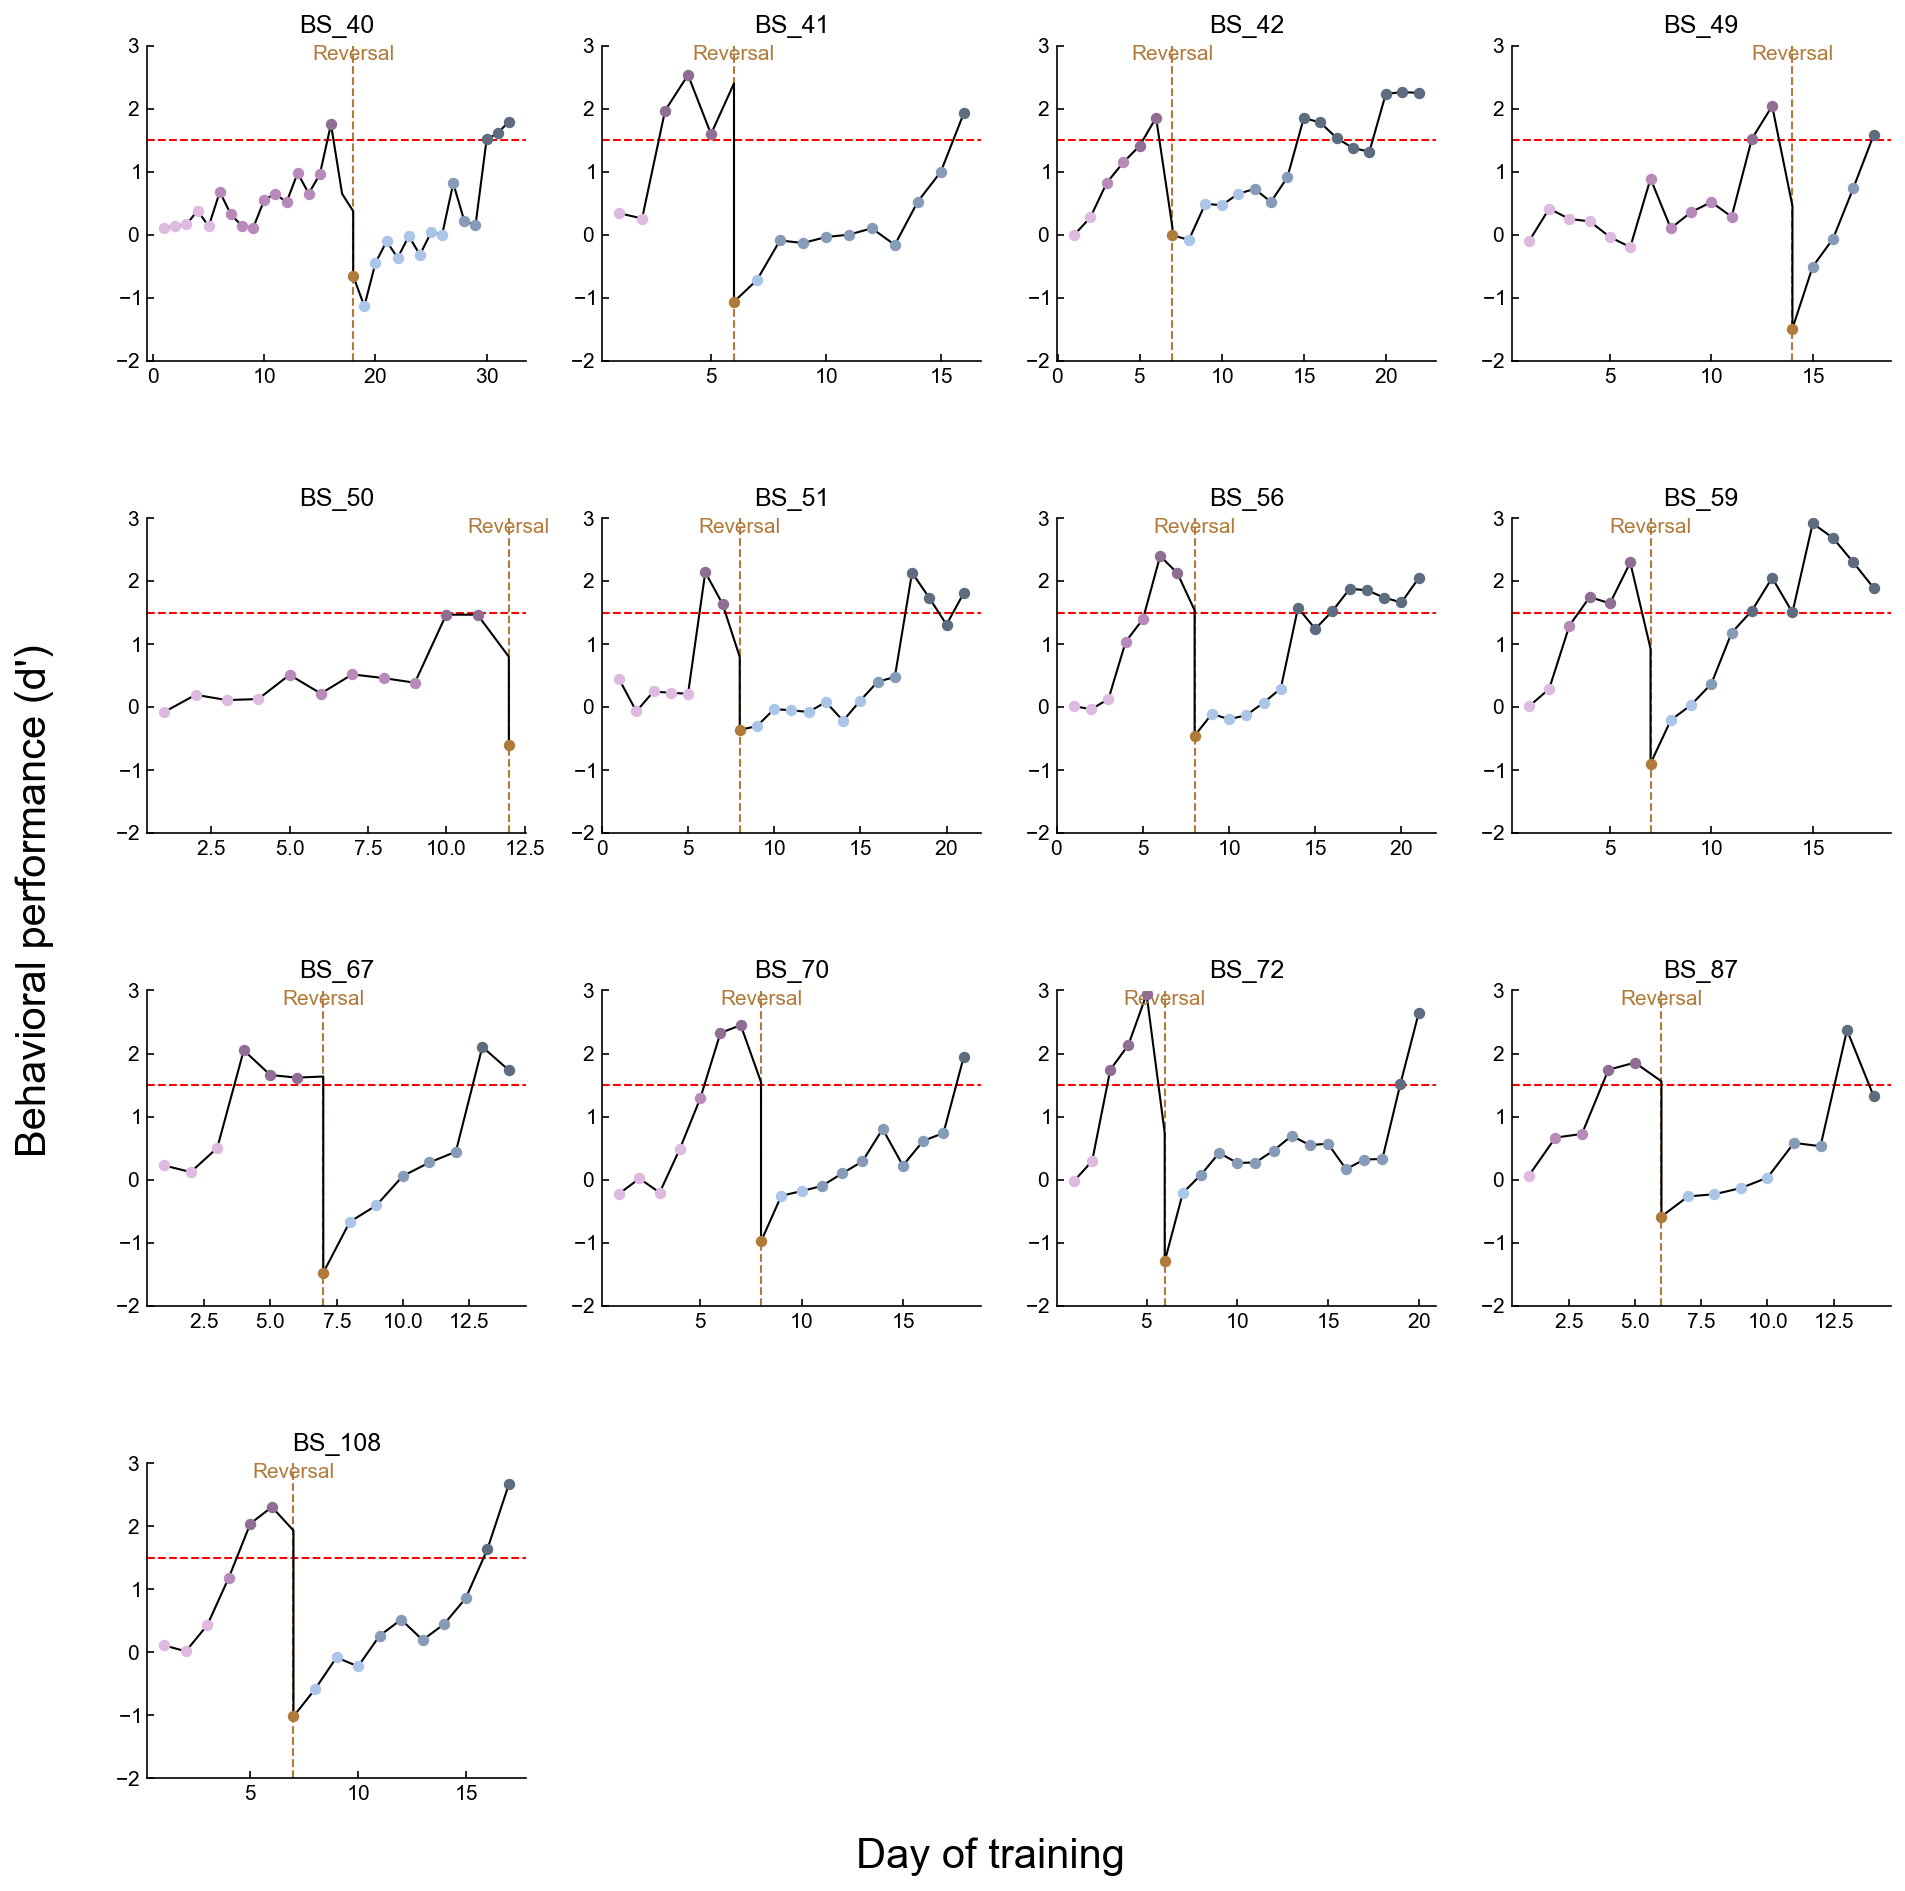

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(BS_animal_M2,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [6]:
act_directory = 'D:\\Analysis_Cache_M2_300'

EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'M2':
        continue
        
    if sessionfile.meta.animal not in BS_animal_M2:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 554/554 [00:09<00:00, 57.89it/s]


In [7]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1624/1624 [00:31<00:00, 51.77it/s] 

errors for: []


In [8]:
act_directory

'D:\\Analysis_Cache_M2_300'

## Stimulus categorization

In [9]:
# 30000 = 1s
# 3000 = 0.1s = 100ms

In [10]:
np.zeros([10,3,2])

array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]])

In [11]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1 #100ms
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window #100ms
    
    #offset window1 start time (100)
    offset_window1_start_time = onset_window_end_time #100ms
    #offset window1 end time (200)
    offset_window1_end_time = offset_window1_start_time + window #200ns
    
    #offset window2 start time (200)
    offset_window2_start_time = offset_window1_end_time #200ns
    #offset window2 end time (300)
    offset_window2_end_time = offset_window1_start_time + window #300ms
    
    
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),3,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window1_start_time[i],offset_window1_end_time[i]],
                             [offset_window2_start_time[i],offset_window2_end_time[i]],
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))
        #spike count from offset window
        spikecount_offsetwindow1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))
        spikecount_offsetwindow2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))
        
        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow1
        spikecounts_stimuluswindow[idx][2]=spikecount_offsetwindow2
        
    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(3)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [8]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1 #100ms
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window #100ms
    #offset window start time
    offset_window_start_time = onset_window_end_time #100ms
    #offset window end time
    offset_window_end_time = offset_window_start_time + window + window #300ms for M2
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [12]:
FRmod_evoked = []
FRmod_suppressed = []
FRmod_NCR = []
FRmod_inc = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue
    if sessionfile.meta.animal not in BS_animal_M2:
        continue
    
    p_evk,p_sup,p_ncr = calculate_NCR_CR_pval(sessionfile,clust)
    
    if p_evk >= 0.95:
        FRmod_evoked.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    elif p_sup >= 0.95:
        FRmod_suppressed.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    elif p_ncr >= 0.95:
        FRmod_NCR.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    else:
        FRmod_inc.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)

1624it [3:05:00,  6.84s/it]


In [13]:
print(len(FRmod_evoked))

83


In [14]:
print(len(FRmod_suppressed))

179


In [15]:
print(len(FRmod_NCR))

428


In [1]:
print(len(FRmod_inc))

NameError: name 'FRmod_inc' is not defined

In [17]:
M2_threshold_300 = SimpleNamespace(FRmod_evoked=FRmod_evoked,
                      FRmod_suppressed=FRmod_suppressed,
                      FRmod_NCR=FRmod_NCR,
                      FRmod_inc=FRmod_inc,
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Multi-region\\Threshold\\M2_threshold_300.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_threshold_300, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
M2_threshold_300 = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Threshold\\M2_threshold_300.pickle')

In [11]:
FRmod_evoked=M2_threshold_300.FRmod_evoked
FRmod_suppressed=M2_threshold_300.FRmod_suppressed
FRmod_NCR=M2_threshold_300.FRmod_NCR
FRmod_inc=M2_threshold_300.FRmod_inc
                     

meta NOT subset; don't know how to subset; dropped


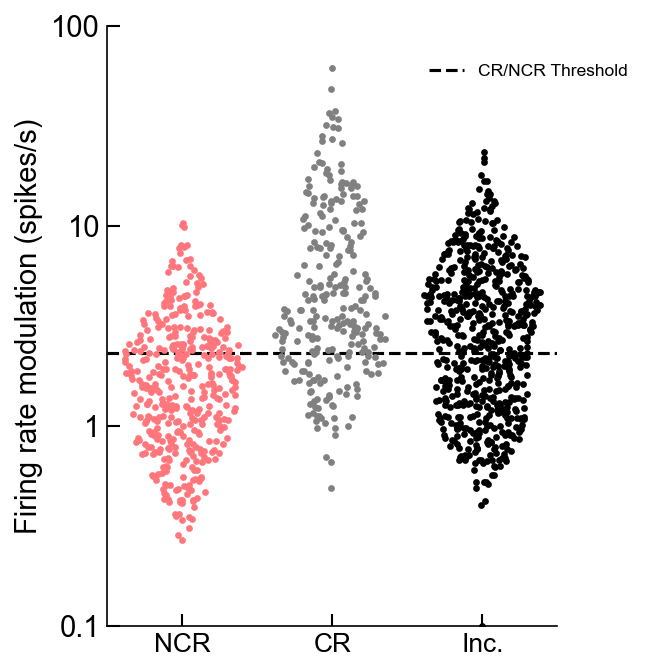

In [21]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

X,Y = ilep.violin(FRmod_NCR,log=True)
#print(X)
ax.scatter(X,Y,s=5,color=NCR_COLOR)

X,Y = ilep.violin(np.concatenate((FRmod_evoked,FRmod_suppressed)),log=True)
ax.scatter(X+1,Y,s=5,color=CR_COLOR)

X,Y = ilep.violin(FRmod_inc,log=True)
ax.scatter(X+2,Y,s=5,color='k')

#ax.axhline(5.28,linestyle='--',color='k',zorder=-10,label='CR/NCR Threshold')
ax.axhline(2.3,linestyle='--',color='k',zorder=-10,label='CR/NCR Threshold')
################################################################################################################

labels = ['NCR','CR','Inc.']

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)


ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

lgd = ax.legend(frameon=False,loc=(0.7,.9))

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,lgd]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Threshold\\CR_NCR_thres_M2_300.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

Text(0, 0.5, 'Firing rate modulation (spikes/s)')

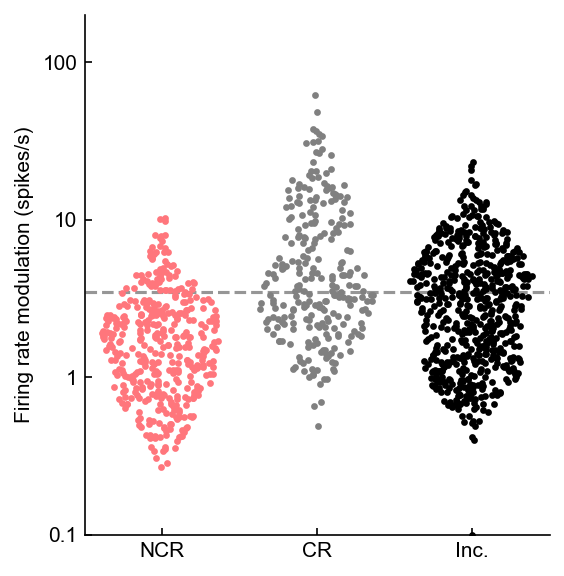

In [13]:
fig, ax = plt.subplots(figsize=(4,4.5))

X,Y = ilep.violin(FRmod_NCR,log=True)
ax.scatter(X,Y,s=5,color=NCR_COLOR)

X,Y = ilep.violin(np.concatenate((FRmod_evoked,FRmod_suppressed)),log=True)
ax.scatter(X+1,Y,s=5,color=CR_COLOR)

X,Y = ilep.violin(FRmod_inc,log=True)
ax.scatter(X+2,Y,s=5,color='k')

ax.axhline(3.5,linestyle='--',color=GOOD_GREY,zorder=-10)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['NCR','CR','Inc.'])

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([str(s) for s in [0.1,1,10,100]])
ax.set_ylabel('Firing rate modulation (spikes/s)')

In [16]:
Mod_NCR = ilep.rmnan(np.abs(FRmod_NCR))
Mod_CR = np.concatenate((ilep.rmnan(np.abs(FRmod_evoked)),ilep.rmnan(np.abs(FRmod_suppressed))))

Mod_NCR = np.vstack((Mod_NCR,np.zeros_like(Mod_NCR))).T
Mod_CR = np.vstack((Mod_CR,np.zeros_like(Mod_CR))).T

X = np.r_[Mod_NCR,Mod_CR]
Y = np.r_[np.zeros(len(Mod_NCR)),np.ones(len(Mod_CR))]

In [17]:
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
x_0 = -clf.intercept_[0]/w[0]
margin = w[0]

print(f"Threshold is {x_0}")

Threshold is 5.282232180196835


## FR mod

In [7]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

ChoiceMod_preearly = []
ChoiceMod_prelate = []
ChoiceMod_preexpert = []
ChoiceMod_postearly = []
ChoiceMod_postlate = []
ChoiceMod_postexpert = []
ChoiceMod_switch = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
analysis_condition = 'all_trials'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if sessionfile.meta.animal not in BS_animal_M2:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(f"{session} - stimulus FRmod: {e}")
    try:
        ChoiceMod = sessionfile.responsiveness[clust][analysis_condition].FRmodulation_choice
    except Exception as e:
        ChoiceMod = np.nan
        print(f"{session} - choice FRmod: {e}")
        
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmod)
        ChoiceMod_preearly.append(ChoiceMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmod)
        ChoiceMod_prelate.append(ChoiceMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(FRmod)
        ChoiceMod_preexpert.append(ChoiceMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmod)
        ChoiceMod_postearly.append(ChoiceMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmod)
        ChoiceMod_postlate.append(ChoiceMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(FRmod)
        ChoiceMod_postexpert.append(ChoiceMod)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

ChoiceMod_preearly = np.array(ChoiceMod_preearly)
ChoiceMod_prelate = np.array(ChoiceMod_prelate)
ChoiceMod_preexpert = np.array(ChoiceMod_preexpert)
ChoiceMod_postearly = np.array(ChoiceMod_postearly)
ChoiceMod_postlate = np.array(ChoiceMod_postlate)
ChoiceMod_postexpert = np.array(ChoiceMod_postexpert)

1624it [00:32, 50.12it/s] 


In [8]:
preearly_animals_M2 = np.unique(preearly_animals)
prelate_animals_M2 = np.unique(prelate_animals)
preexpert_animals_M2 = np.unique(preexpert_animals)
postearly_animals_M2 = np.unique(postearly_animals)
postlate_animals_M2 = np.unique(postlate_animals)
postexpert_animals_M2 = np.unique(postexpert_animals)

In [9]:
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)

['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67']


In [10]:
len(FRmod_postearly)+len(FRmod_postlate)+len(FRmod_postexpert)

745

In [11]:
len(FRmod_preearly)+len(FRmod_prelate)+len(FRmod_preexpert)

598

In [12]:
#771+598

In [13]:
745+598

1343

C:\Users\insan\AppData\Local\Temp\ipykernel_30132\1106762458.py:36: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


2.6326963906581744
1.7656012176560139
3.1578947368421075
2.2879354540488297
2.3308270676691745
3.7283792440743113


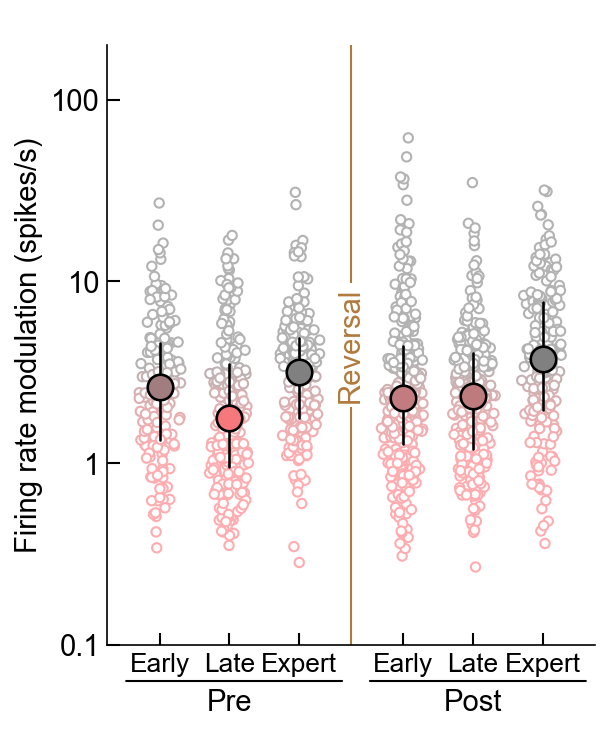

In [11]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 2.3
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 2.3
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\FRmod\\FRmod overlearning M2 all cells_300.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [12]:
FRData = SimpleNamespace()
FRData.preearly = FRmod_preearly
FRData.prelate = FRmod_prelate
FRData.preexpert = FRmod_preexpert
FRData.postearly = FRmod_postearly
FRData.postlate = FRmod_postlate
FRData.postexpert = FRmod_postexpert

In [17]:
ilep.nonparametricIndependentStatsCompareToPrevious(FRData)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS      DF          MS          F         p-unc  \
0            phase    254.224105     3.0   84.741368   4.303808  4.929280e-03   
1          context     53.564616     1.0   53.564616   2.720417  9.924741e-02   
2  phase * context    836.729132     3.0  278.909711  14.165147  3.990439e-09   
3         Residual  35284.222798  1792.0   19.689856        NaN           NaN   

        np2  
0  0.007153  
1  0.001516  
2  0.023165  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.034380e-07  2.068760e-07 -0.499898
8     post-late  baseline  experimental  4.218176e-01  4.218176e-01  0.177763
9    pre-expert  baseline  experimental  6.370628e-09  2.548251e-08 -0.341704
10     pre-late  baseline  experimental  4.640861e-04  6.187814e-04  0.236764
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 3

In [18]:
2.068760e-07 < 0.0001

True

In [21]:
6.187814e-04 < 0.001

True

In [16]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(FRData)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS      DF          MS         F     p-unc  \
0            phase    479.659539     3.0  159.886513  6.324125  0.000290   
1          context      1.747034     1.0    1.747034  0.069102  0.792680   
2  phase * context    400.161680     3.0  133.387227  5.275977  0.001269   
3         Residual  44774.416534  1771.0   25.281997       NaN       NaN   

        np2  
0  0.010599  
1  0.000039  
2  0.008858  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000007  0.000027 -0.212335
8     post-late  baseline  experimental  0.421818  0.421818  0.177763
9    pre-expert  baseline  experimental  0.061238  0.081651 -0.103047
10     pre-late  baseline  experimental  0.000464  0.000928  0.236764
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 306 non-nan elements
key postlate has 247 non-nan elements
key pos

## Stimulus FRmod

C:\Users\insan\AppData\Local\Temp\ipykernel_12592\4222531746.py:36: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


2.3406478578892433
1.3013698630136985
2.5592417061611363
1.882818652067924
1.8702865761689287
3.2829406631762637


meta NOT subset; don't know how to subset; dropped


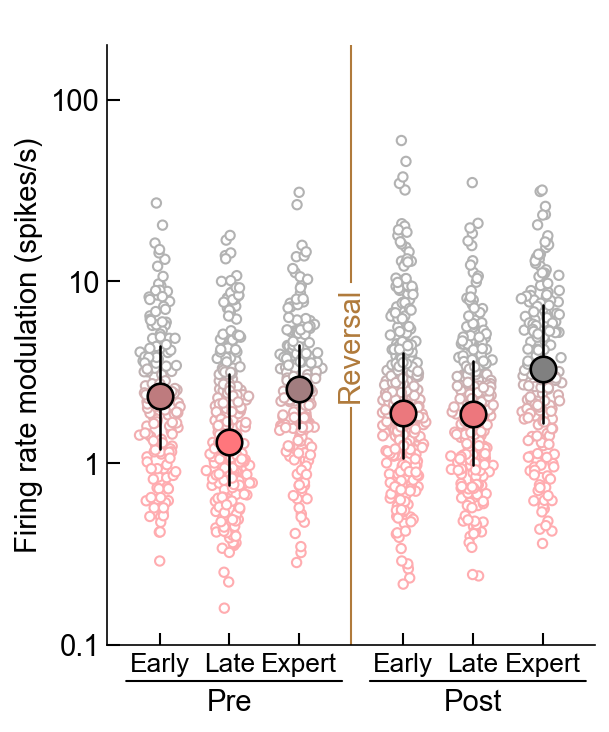

In [20]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 2.3
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 2.3
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\FRmod\\FRmod overlearning M2 all cells.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [15]:
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]

In [16]:
FRData = SimpleNamespace()
FRData.preearly = FRmod_preearly
FRData.prelate = FRmod_prelate
FRData.preexpert = FRmod_preexpert
FRData.postearly = FRmod_postearly
FRData.postlate = FRmod_postlate
FRData.postexpert = FRmod_postexpert

In [17]:
ilep.nonparametricIndependentStatsCompareToPrevious(FRData)

            Source            SS      DF          MS          F         p-unc  \
0            phase    318.298076     3.0  106.099359   5.649268  7.505901e-04   
1          context     42.051026     1.0   42.051026   2.239010  1.347432e-01   
2  phase * context    858.034654     3.0  286.011551  15.228706  8.699339e-10   
3         Residual  33655.695787  1792.0   18.781080        NaN           NaN   

        np2  
0  0.009369  
1  0.001248  
2  0.024861  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  4.248561e-08  8.497121e-08 -0.499798
8     post-late  baseline  experimental  2.907463e-01  2.907463e-01  0.171919
9    pre-expert  baseline  experimental  1.129214e-08  4.516855e-08 -0.336083
10     pre-late  baseline  experimental  1.608033e-05  2.144043e-05  0.305536
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 3

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,129816.0,two-sided,7.487483e-03,1.497497e-02,fdr_bh,0.092013
1,phase,-,post-expert,pre-expert,False,False,101442.0,two-sided,1.496378e-03,4.489135e-03,fdr_bh,0.232894
2,phase,-,post-expert,pre-late,False,False,98730.5,two-sided,5.764524e-05,3.458714e-04,fdr_bh,0.254163
3,phase,-,post-late,pre-expert,False,False,119808.0,two-sided,4.732637e-01,4.732637e-01,fdr_bh,0.108237
4,phase,-,post-late,pre-late,False,False,117541.5,two-sided,7.290596e-02,1.093589e-01,fdr_bh,0.126907
5,phase,-,pre-expert,pre-late,False,False,87204.0,two-sided,3.413393e-01,4.096071e-01,fdr_bh,0.025503
6,context,-,baseline,experimental,False,False,378090.5,two-sided,2.000021e-02,NaN,NaN,-0.052683
7,phase * context,post-expert,baseline,experimental,False,False,15328.5,two-sided,4.248561e-08,8.497121e-08,fdr_bh,-0.499798
8,phase * context,post-late,baseline,experimental,False,False,39765.0,two-sided,2.907463e-01,2.907463e-01,fdr_bh,0.171919
9,phase * context,pre-expert,baseline,experimental,False,False,14778.0,two-sided,1.129214e-08,4.516855e-08,fdr_bh,-0.336083


In [21]:
8.497121e-08 < 0.0001

True

In [22]:
2.144043e-05 <0.0001

True

In [23]:
2.907463e-01 

0.2907463

In [18]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(FRData)

            Source            SS      DF          MS         F     p-unc  \
0            phase    487.754986     3.0  162.584995  6.803037  0.000147   
1          context      6.753254     1.0    6.753254  0.282576  0.595084   
2  phase * context    427.032364     3.0  142.344121  5.956099  0.000487   
3         Residual  42324.924817  1771.0   23.898885       NaN       NaN   

        np2  
0  0.011393  
1  0.000160  
2  0.009989  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000005  0.000020 -0.231437
8     post-late  baseline  experimental  0.290746  0.290746  0.171919
9    pre-expert  baseline  experimental  0.280595  0.290746 -0.031084
10     pre-late  baseline  experimental  0.000016  0.000032  0.305536
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 306 non-nan elements
key postlate has 247 non-nan elements
key pos

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,150077.5,two-sided,0.001143,0.001720,fdr_bh,0.162866
1,phase,-,post-expert,pre-expert,False,False,83251.0,two-sided,0.965986,0.965986,fdr_bh,0.158477
2,phase,-,post-expert,pre-late,False,False,114027.0,two-sided,0.000005,0.000025,fdr_bh,0.300325
3,phase,-,post-late,pre-expert,False,False,82342.5,two-sided,0.001147,0.001720,fdr_bh,-0.019084
4,phase,-,post-late,pre-late,False,False,117541.5,two-sided,0.072906,0.087487,fdr_bh,0.126907
5,phase,-,pre-expert,pre-late,False,False,80982.0,two-sided,0.000008,0.000025,fdr_bh,0.188233
6,context,-,baseline,experimental,False,False,398265.0,two-sided,0.747820,NaN,NaN,0.058762
7,phase * context,post-expert,baseline,experimental,False,False,20717.0,two-sided,0.000005,0.000020,fdr_bh,-0.231437
8,phase * context,post-late,baseline,experimental,False,False,39765.0,two-sided,0.290746,0.290746,fdr_bh,0.171919
9,phase * context,pre-expert,baseline,experimental,False,False,13564.0,two-sided,0.280595,0.290746,fdr_bh,-0.031084


In [19]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

## Choice FRmod

In [ ]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75


FRmod_baseline_median = 0.7682453632156631 
mn = FRmod_baseline_median
spread = 1
    
###

data = [ChoiceMod_preearly,ChoiceMod_prelate,ChoiceMod_preexpert,ChoiceMod_postearly,ChoiceMod_postlate,ChoiceMod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# ax.axhline(1.9)

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_oringinal\\Figures\ChoiceMod overlearning M2.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\PHRC_Dual\\Choicemod\\ChoiceMod overlearning M2 correct color.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [26]:
ChoiceData = SimpleNamespace()
ChoiceData.preearly = ChoiceMod_preearly
ChoiceData.prelate = ChoiceMod_prelate
ChoiceData.preexpert = ChoiceMod_preexpert
ChoiceData.postearly = ChoiceMod_postearly
ChoiceData.postlate = ChoiceMod_postlate
ChoiceData.postexpert = ChoiceMod_postexpert

In [27]:
ilep.nonparametricIndependentStatsCompareToPrevious(ChoiceData)

            Source            SS      DF         MS         F     p-unc  \
0            phase     37.620149     3.0  12.540050  1.212156  0.303823   
1          context      1.858244     1.0   1.858244  0.179623  0.671749   
2  phase * context    109.365050     3.0  36.455017  3.523842  0.014471   
3         Residual  18331.778685  1772.0  10.345248       NaN       NaN   

        np2  
0  0.002048  
1  0.000101  
2  0.005930  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.111301  0.148402 -0.172536
8     post-late  baseline  experimental  0.854484  0.854484  0.157575
9    pre-expert  baseline  experimental  0.029971  0.119883 -0.116644
10     pre-late  baseline  experimental  0.090126  0.148402 -0.201114
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 349 non-nan elements
key postlate has 204 non-nan elements
key postexpe

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,117895.0,two-sided,0.206851,0.310276,fdr_bh,-0.064302
1,phase,-,post-expert,pre-expert,False,False,82106.5,two-sided,0.274041,0.328849,fdr_bh,-0.094929
2,phase,-,post-expert,pre-late,False,False,85445.0,two-sided,0.177159,0.310276,fdr_bh,0.034288
3,phase,-,post-late,pre-expert,False,False,106096.5,two-sided,0.015105,0.053702,fdr_bh,-0.000776
4,phase,-,post-late,pre-late,False,False,110705.0,two-sided,0.874970,0.874970,fdr_bh,0.085999
5,phase,-,pre-expert,pre-late,False,False,92004.5,two-sided,0.017901,0.053702,fdr_bh,0.127645
6,context,-,baseline,experimental,False,False,365765.0,two-sided,0.008596,NaN,NaN,-0.005505
7,phase * context,post-expert,baseline,experimental,False,False,18816.0,two-sided,0.111301,0.148402,fdr_bh,-0.172536
8,phase * context,post-late,baseline,experimental,False,False,35265.0,two-sided,0.854484,0.854484,fdr_bh,0.157575
9,phase * context,pre-expert,baseline,experimental,False,False,19173.0,two-sided,0.029971,0.119883,fdr_bh,-0.116644


In [28]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(ChoiceData)

            Source            SS      DF         MS         F     p-unc  \
0            phase     53.767738     3.0  17.922579  1.249452  0.290283   
1          context      0.692420     1.0   0.692420  0.048271  0.826124   
2  phase * context    145.975726     3.0  48.658575  3.392175  0.017324   
3         Residual  26350.584862  1837.0  14.344358       NaN       NaN   

        np2  
0  0.002036  
1  0.000026  
2  0.005509  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.082639  0.120168  0.065013
8     post-late  baseline  experimental  0.854484  0.854484  0.157575
9    pre-expert  baseline  experimental  0.000173  0.000692 -0.306517
10     pre-late  baseline  experimental  0.090126  0.120168 -0.201114
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 349 non-nan elements
key postlate has 204 non-nan elements
key postexpe

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,157321.5,two-sided,0.376279,0.564419,fdr_bh,0.033667
1,phase,-,post-expert,pre-expert,False,False,92301.0,two-sided,0.577447,0.692937,fdr_bh,0.085308
2,phase,-,post-expert,pre-late,False,False,114025.0,two-sided,0.316863,0.564419,fdr_bh,0.125501
3,phase,-,post-late,pre-expert,False,False,89231.5,two-sided,0.156006,0.468019,fdr_bh,0.046851
4,phase,-,post-late,pre-late,False,False,110705.0,two-sided,0.874970,0.874970,fdr_bh,0.085999
5,phase,-,pre-expert,pre-late,False,False,72273.5,two-sided,0.145983,0.468019,fdr_bh,0.057209
6,context,-,baseline,experimental,False,False,382342.0,two-sided,0.000655,NaN,NaN,0.028102
7,phase * context,post-expert,baseline,experimental,False,False,32287.0,two-sided,0.082639,0.120168,fdr_bh,0.065013
8,phase * context,post-late,baseline,experimental,False,False,35265.0,two-sided,0.854484,0.854484,fdr_bh,0.157575
9,phase * context,pre-expert,baseline,experimental,False,False,11123.0,two-sided,0.000173,0.000692,fdr_bh,-0.306517


In [35]:
ChoiceMod_preearly

array([1.93315266e+00, 1.13821138e+00, 1.11111111e+00, 1.26377597e+01,
       3.08943089e+00, 1.32897603e+00, 6.25000000e-01, 5.55555556e-01,
       1.45438121e+00, 7.77338603e-01, 2.28723404e+00, 5.60747664e-01,
       1.88261351e-01, 3.52303523e-01, 5.05871725e-01, 9.12375790e-01,
       2.13043478e+00, 8.94308943e-01, 1.92176871e+00, 9.32203390e-01,
       6.26919603e+00, 2.80036134e-01, 1.58878505e+00, 2.38948626e-02,
       7.27630285e-01, 4.51977401e-01, 3.55029586e-01, 2.44252874e-01,
       1.13686838e-16, 9.84643180e-01, 1.70940171e-01, 8.88888889e-02,
       2.90196078e-01, 4.96657116e-01, 9.20634921e-01, 1.48619958e-01,
       1.41280353e+00, 2.90196078e-01, 6.03921569e-01, 5.41176471e-01,
       1.24610592e+00, 7.90960452e-01, 2.28758170e-01, 9.45945946e-01,
       1.88235294e-01, 1.68115942e+00, 1.41176471e+00, 5.46448087e-02,
       1.86666667e+00, 4.66666667e-01, 5.00000000e-01, 9.33333333e-01,
       7.66666667e-01, 1.33333333e-01, 8.33333333e-01, 4.33333333e-01,
      

In [1]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

## Choice categorization

In [58]:
sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice

KeyError: 68

In [48]:
#this function calculates pval for one cluster(one cell)
def calculate_choice_NCR_CR_pval(sessionfile,clust):
    
    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trials_to_use = allConditions['go'].trials
    #trials_to_use = allConditions['all_trials'].trials

    if len(trials_to_use) < 30:
        print('not enough trials to use')
        return np.nan,np.nan,np.nan
    
    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.response[trial] - window*0.5
    
    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    baseline_reference_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        baseline_reference_window_start_time[idx] = sessionfile.trials.starts[trial]
    base_window1_start = baseline_reference_window_start_time - 3*window
    base_window1_end = baseline_reference_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = baseline_reference_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = baseline_reference_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)
        
        #print(spikecounts_diff)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        
        #print(spikecounts_diff_mean)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    print('p values')
    print(p_value_evoked)
    print(p_value_suppressed)
    print(p_value_NCR)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [49]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_41_2_M2.pickle')

In [50]:
sessionfile.clusters.good

array([  3,   4,  17,  18,  20,  23,  25,  31,  32,  33,  41,  42,  48,
        49,  52,  53,  54,  55,  59,  65,  73,  75,  78,  82,  89, 101,
       105, 107, 112, 113, 116], dtype=int64)

In [51]:
test_cluster = sessionfile.clusters.good[10]

In [52]:
a = [26829.0, 26827.0, 0.0, 1.0, 26828.0, 0.0, 26827.0, 0.0, 26829.0, 26829.0, 26828.0, -3.0, 0.0, 0.0, -2.0, 26828.0, 26826.0, 0.0, 1.0, 0.0, 0.0, 26827.0, 26828.0, 26829.0, 26827.0, 26829.0, 26829.0, 26830.0, -2.0, 0.0, 26826.0, -2.0, 26828.0, 2.0, 26829.0, 26830.0, -2.0, 26830.0, 26828.0, 0.0, 26830.0, 26829.0, 26829.0, 0.0, -2.0, 26829.0, 0.0, 0.0, 26828.0, 26830.0, 26830.0, 0.0, 26830.0, 1.0, 26828.0, -1.0, 1.0, 2.0, 0.0, 26829.0, 26830.0, 0.0, 0.0, 1.0, 26830.0, 2.0, 26830.0, 26830.0, 1.0, 26829.0, 1.0, 26827.0, 26830.0, 26828.0, 26828.0, 26825.0, 0.0, 26830.0, 26829.0, 26830.0, 26829.0, 26830.0, 26827.0, 1.0, 26830.0, 0.0, 1.0, 1.0, -1.0, -2.0, 26830.0, 26829.0, 26829.0, 1.0, 26827.0, -2.0, 26828.0, 2.0, 26830.0, 26830.0, 26829.0, 26829.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 26828.0, 0.0, 26828.0, 0.0, 0.0, 1.0, 26829.0, 1.0, -1.0, 1.0, 1.0, 2.0, 0.0, 26828.0, 0.0, 26829.0, 2.0, 26830.0, 26829.0, 0.0, 0.0, 26829.0, -1.0, 26827.0, 26830.0, 0.0, 26828.0, 26829.0, 26830.0, 26830.0, 0.0, 0.0, 26830.0, 26830.0, 26830.0, 26823.0, 26828.0, 26830.0, 26828.0, 26829.0, 0.0, 26828.0, 0.0, 26828.0, -2.0, 0.0, 0.0, 26829.0, 26828.0, 26828.0, 26829.0, 26829.0, -1.0, 1.0, 1.0, 26830.0, 26830.0, 26830.0, 26828.0, 26829.0, 0.0, 26830.0, 0.0, 0.0, 0.0, 0.0, 3.0, 26830.0, 0.0, 0.0, 1.0, 0.0, -1.0, 26827.0, 26830.0, 0.0, 26828.0, -1.0, 26829.0, 26829.0, 26828.0, 26826.0, -1.0, -1.0, 26829.0, -1.0, 26828.0, 26830.0, -1.0, 26829.0, 26830.0, 26830.0, 26828.0, 26828.0, 26830.0, 26827.0, 1.0, 26829.0, 26827.0, 26830.0, 0.0, 26828.0, 1.0, 26827.0, 26830.0, 1.0, 26829.0, 0.0, 26830.0, 26830.0, 0.0, 26828.0, 26828.0, 26830.0, 26829.0, 26830.0, -1.0, 0.0, 26830.0, 26830.0, 26828.0, 26830.0, 26828.0, 26828.0, 26830.0, 1.0, 26828.0, 26828.0, 0.0, 0.0, 2.0, 26830.0, 26828.0, 26823.0, 1.0, 0.0, -1.0, 2.0, 0.0, 26830.0, 0.0, 26829.0, 26829.0, -1.0, 1.0, 1.0, 26827.0, 0.0, 26830.0, 26830.0, 26830.0, 26828.0, -2.0, 26830.0, -2.0, 26830.0, -1.0, 0.0, 26830.0, 0.0, 26828.0, 0.0, 26828.0, 1.0, 26830.0, 26828.0, 26828.0, 26830.0, 1.0, 26828.0, 26828.0, 3.0, 0.0, 3.0, 26827.0, 0.0, 1.0, 26830.0, 1.0, 0.0, 1.0, 26828.0, 2.0, 26830.0, 26827.0, 0.0, 26825.0, 1.0, 26830.0, -1.0, 26830.0, 26829.0, 26830.0, 1.0, 0.0, 26826.0, 26828.0, 26829.0, 0.0, 26827.0, 0.0, 26829.0, 0.0, 26828.0, 26828.0, 0.0, 0.0, 26830.0, 1.0, 26828.0, 26830.0, 26830.0, 26828.0, 26829.0, 26827.0, 26830.0, 0.0, 0.0, -1.0, 0.0, 1.0, -2.0, 26826.0, 26828.0, -1.0, 0.0, 0.0, 1.0, -1.0, 26829.0, 26830.0, 26829.0, -1.0, 0.0]

In [53]:
np.mean(a)

14548.580174927114

In [55]:
calculate_choice_NCR_CR_pval(sessionfile,test_cluster)

p values
0.6722
0.0008
0.327


(0.6722, 0.0008, 0.327)

In [62]:
#############final

In [63]:
#this function calculates pval for one cluster(one cell)
def calculate_choice_NCR_CR_pval(sessionfile,clust):
    
    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trials_to_use = allConditions['go'].trials #This is correct. Must use go.
    #trials_to_use = allConditions['all_trials'].trials

    if len(trials_to_use) < 30:
        #print('not enough trials to use')
        return np.nan,np.nan,np.nan
    
    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.response[trial] - window*0.5
    
    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    baseline_reference_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        baseline_reference_window_start_time[idx] = sessionfile.trials.starts[trial]
    base_window1_start = baseline_reference_window_start_time - 3*window
    base_window1_end = baseline_reference_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = baseline_reference_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = baseline_reference_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)
        
        #print(spikecounts_diff)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        
        #print(spikecounts_diff_mean)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)

    return p_value_evoked, p_value_suppressed, p_value_NCR

In [64]:
ChoiceMod_evoked = []
ChoiceMod_suppressed = []
ChoiceMod_NCR = []
ChoiceMod_inc = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue
    if sessionfile.meta.animal not in BS_animal_M2:
        continue
    
    p_evk,p_sup,p_ncr = calculate_choice_NCR_CR_pval(sessionfile,clust)
    
    if p_evk >= 0.95:
        ChoiceMod_evoked.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice)
    elif p_sup >= 0.95:
        ChoiceMod_suppressed.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice)
    elif p_ncr >= 0.95:
        ChoiceMod_NCR.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice)
    else:
        ChoiceMod_inc.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice)

1628it [1:45:32,  3.89s/it]


In [65]:
ChoiceModFR_NCR = ilep.rmnan(np.abs(ChoiceMod_NCR))
ChoiceModFR_CR = np.concatenate((ilep.rmnan(np.abs(ChoiceMod_evoked)),ilep.rmnan(np.abs(ChoiceMod_suppressed))))

ChoiceModFR_NCR = np.vstack((ChoiceModFR_NCR,np.zeros_like(ChoiceModFR_NCR))).T
ChoiceModFR_CR = np.vstack((ChoiceModFR_CR,np.zeros_like(ChoiceModFR_CR))).T

X = np.r_[ChoiceModFR_NCR,ChoiceModFR_CR]
Y = np.r_[np.zeros(len(ChoiceModFR_NCR)),np.ones(len(ChoiceModFR_CR))]

In [66]:
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
x_0 = -clf.intercept_[0]/w[0]
margin = w[0]

print(f"Threshold is {x_0}")

Threshold is 0.7682453632156631


In [69]:
ChoiceMod_thresh = 0.7682453632156631

meta NOT subset; don't know how to subset; dropped


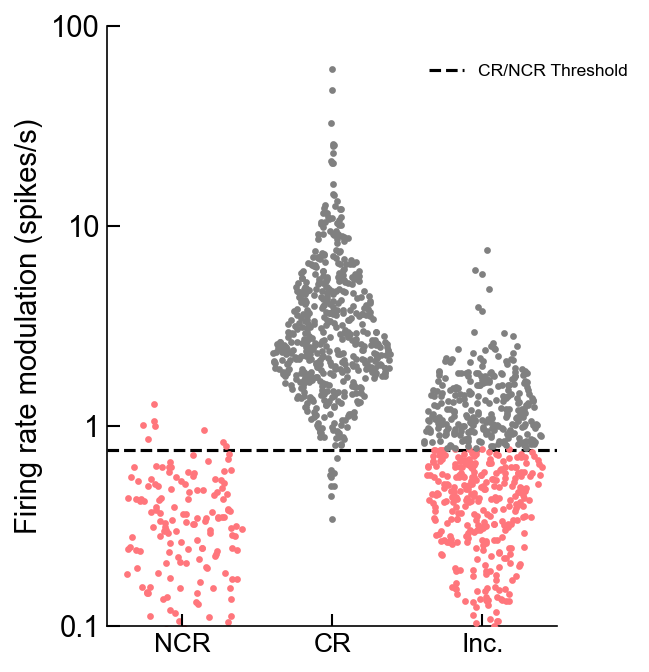

In [71]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

X,Y = ilep.violin(ilep.rmnan(np.abs(ChoiceMod_NCR)),log=True)
ax.scatter(X,Y,s=5,color=NCR_COLOR)

X,Y = ilep.violin(np.concatenate((ilep.rmnan(np.abs(ChoiceMod_evoked)),ilep.rmnan(np.abs(ChoiceMod_suppressed)))),log=True)
ax.scatter(X+1,Y,s=5,color=CR_COLOR)

X,Y = ilep.violin(ilep.rmnan(np.abs(ChoiceMod_inc)),log=True)
up_mask = np.greater(Y,ChoiceMod_thresh)
ax.scatter(X[up_mask]+2,Y[up_mask],s=5,color=CR_COLOR,zorder=4)
ax.scatter(X[~up_mask]+2,Y[~up_mask],s=5,color=NCR_COLOR,zorder=3)

ax.axhline(0.76,linestyle='--',color='k',zorder=-10,label='CR/NCR Threshold')

################################################################################################################

labels = ['NCR','CR','Inc.']

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

lgd = ax.legend(frameon=False,loc=(0.7,.9))

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,lgd]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\PHRC_Dual\\Threshold\\CR_NCR_thres_M2_choice.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')